## Understanding NeuralStyleTransfer
1. Style is the correlation between the different filter response of a feature maps (gram matrix)
2. losses (hyperparam - style/content weight)
    - content loss (MSE of feature representation)
    - style loss (Gram matrix)

## Steps
1. Create style_content_extractor using VGG16 backbone
2. Pass target image(painting) to get the target style and content
3. Train the network with the input image to minizie style and content loss




## Importing libraries

In [2]:
!pip install tqdm

  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)


In [26]:
#tensorflow 
import tensorflow as tf

#numeric lib
import numpy as np

#computer vision lib
import PIL
from PIL import Image

#python
import os
import random 
import time
from tqdm import tqdm
import IPython.display as display

#ploting lib
import matplotlib.pyplot as plt

In [4]:
class CONFIG:
    seed = 42
    style_weight = 1e-2
    content_weight =1e4
    total_variation_weight=30

In [5]:
def seed_python(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def seed_tf(seed):
    tf.random.set_seed(seed)

seed_python(CONFIG.seed)
seed_tf(CONFIG.seed)

## Loading sample images

In [6]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [8]:
def tf_loadimg(filepath, max_image_dim=512):
    """
    We will not be normalizing the image as we will be usinng vgg19.preprocess function
    """
    bin_img = tf.io.read_file(filepath)
    image_tensor = tf.io.decode_jpeg(bin_img, channels=3)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    max_dim = tf.reduce_max(image_tensor.shape)
    scale = tf.cast(512/max_dim, tf.float32)
    new_size = scale*tf.cast(image_tensor.shape[:-1],tf.float32)
    new_size = tf.cast(tf.round(new_size),tf.int32)

    image_tensor = tf.image.resize(image_tensor, new_size)
    return tf.expand_dims(image_tensor,0)

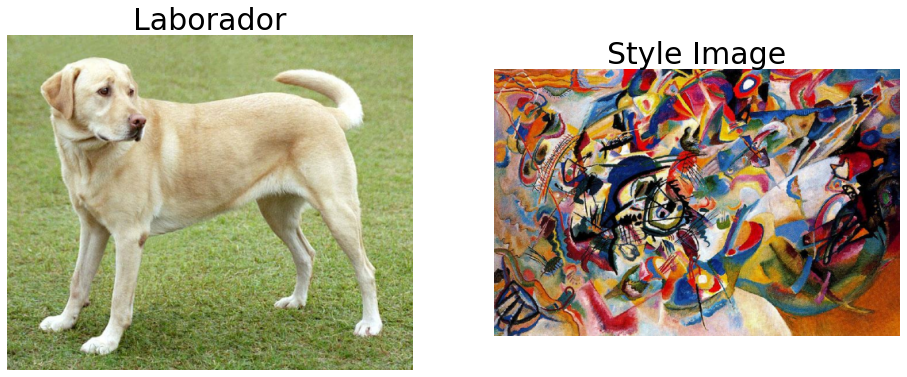

In [9]:
content_image = tf_loadimg(content_path)
style_image = tf_loadimg(style_path)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes[0].imshow(tf.squeeze(content_image, axis=0))
axes[0].set_title("Laborador", fontsize=30)
axes[0].axis("off")

axes[1].imshow(tf.squeeze(style_image, axis=0))
axes[1].set_title("Style Image", fontsize=30)
axes[1].axis("off")

plt.show()

## Import VGG19 and testing

In [10]:
content_image = tf_loadimg(content_path)
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (224,224))

# downloading the vgg model
vgg19_model = tf.keras.applications.VGG19()
prediction_proba = vgg19_model(content_image)

#Prediction
tf.keras.applications.vgg19.decode_predictions(prediction_proba.numpy(), top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n02099712', 'Labrador_retriever', 0.49317262),
  ('n02099601', 'golden_retriever', 0.23665187),
  ('n02104029', 'kuvasz', 0.036357313),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.024182795),
  ('n02107574', 'Greater_Swiss_Mountain_dog', 0.01864602)]]

## Selecting the layers that are used in the original paper

In [11]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Creating a wrapper around vgg19 that returns all these layers as outputs


In [12]:
def get_modified_vgg_model(required_layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_input = vgg.input
    outputs = [vgg.get_layer(name).output for name in required_layer_names]

    return tf.keras.Model(inputs=[vgg_input], outputs = outputs)

In [13]:
style_extractor = get_modified_vgg_model(style_layers)
style_ouput = style_extractor(style_image)
for name, output in zip(style_layers, style_ouput):
    print(name)
    print(output.numpy().shape)

80142336/80134624 [==============================] - 3s 0us/step
block1_conv1
(1, 336, 512, 64)
block2_conv1
(1, 168, 256, 128)
block3_conv1
(1, 84, 128, 256)
block4_conv1
(1, 42, 64, 512)
block5_conv1
(1, 21, 32, 512)


In [14]:
def cal_gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    return result/tf.cast(input_shape[1]*input_shape[2], dtype=tf.float32)

## Creating the style extractor can extracting the target style

In [15]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = get_modified_vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, image_tensor):
        image_tensor = image_tensor * 255.0
        model_inputs = tf.keras.applications.vgg19.preprocess_input(image_tensor)
        model_outputs = self.vgg(model_inputs)
        style_outputs = model_outputs[:self.num_style_layers]
        content_outputs = model_outputs[self.num_style_layers:]

        extracted_style = {layer_name: cal_gram_matrix(tensor) for layer_name, tensor in zip(self.style_layers, style_outputs)}
        extracted_content = {layer_name: tensor for layer_name, tensor in zip(self.content_layers, content_outputs)}

        return {
            'content':extracted_content,
            'style':extracted_style
        }


In [16]:
content_image = tf_loadimg(content_path)
content_image = tf.image.resize(content_image,(224,224))
style_image = tf_loadimg(style_path)
extractor = StyleContentExtractor(style_layers, content_layers)
target_style = extractor(style_image)['style']
target_content = extractor(content_image)['content']

## Compute loss function
The loss is the sum of the content and style mse loss

In [17]:
def style_content_loss(model_outputs, target_style_tensors, target_content_tensor):
    style_outputs = model_outputs['style'] # {layer_name:tensor ... }
    content_outputs = model_outputs['content']  # {layer_name:tensor ... }

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[layer_name] - target_style_tensors[layer_name])**2)
                           for layer_name in target_style_tensors.keys()])

    style_loss *= CONFIG.style_weight/num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[layer_name] - target_content_tensor[layer_name])**2)
                           for layer_name in target_content_tensor.keys()])
    
    content_loss *= CONFIG.content_weight/num_content_layers
    
    return content_loss + style_loss


In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Training loop

In [20]:
#initializing variables and optimizers
image = tf.Variable(content_image)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [21]:
@tf.function()
def train_step(input_image):
    with tf.GradientTape() as tape:
        model_outputs = extractor(input_image)
        loss = style_content_loss(model_outputs,target_style,target_content)
        loss += CONFIG.total_variation_weight * tf.image.total_variation(input_image)

    grad = tape.gradient(loss, input_image)
    optimizer.apply_gradients([(grad,input_image)])
    input_image.assign(clip_0_1(input_image))
    


In [22]:
def tensor_to_image(tensor):
    tensor = tensor *255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


  0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x0000010E3FE07730>
Traceback (most recent call last):
  File "C:\Users\teozz\miniconda3\envs\neural_style_transfer\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\teozz\miniconda3\envs\neural_style_transfer\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [01:39<00:14,  2.46s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.27s/it]


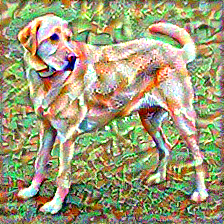

Train step: 50


In [27]:
epochs = 1
steps_per_epoch = 50


step = 0
for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
        step += 1
        train_step(image)

    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
